This playbook is inspired by lessons in [Advanced Retrieval for AI with Chroma](https://learn.deeplearning.ai/courses/advanced-retrieval-for-ai/)

## Setup

In [ ]:
# %pip install glob langchain-huggingface langchain-community langchain-chroma langchain-ollama --user

In [1]:
# Document Loading
import glob
from langchain_community.document_loaders import JSONLoader

FHIR_BUNDLE_JQ_SCHEMA = ".entry[]"
FHIR_BUNDLE_CONTENT_KEY = ".resource"

synthea_bundles = glob.glob("../fhir/*.json")

loaders = [
    JSONLoader(
        file_path=xpath,
        jq_schema=FHIR_BUNDLE_JQ_SCHEMA,
        content_key=FHIR_BUNDLE_CONTENT_KEY,
        is_content_key_jq_parsable=True,
        text_content=False
    )
    for xpath in synthea_bundles[:10] # limiting to just the first 10 for now
]

docs = []
for loader in loaders:
    docs.extend(loader.load())
print(len(docs))
print(docs[5])

2961
page_content='{"resourceType": "Condition", "id": "0472ed1c-4efa-4c86-bcf1-5eea6bda2432", "clinicalStatus": {"coding": [{"system": "http://terminology.hl7.org/CodeSystem/condition-clinical", "code": "active"}]}, "verificationStatus": {"coding": [{"system": "http://terminology.hl7.org/CodeSystem/condition-ver-status", "code": "confirmed"}]}, "code": {"coding": [{"system": "http://snomed.info/sct", "code": "429007001", "display": "History of cardiac arrest (situation)"}], "text": "History of cardiac arrest (situation)"}, "subject": {"reference": "urn:uuid:5cbc121b-cd71-4428-b8b7-31e53eba8184"}, "encounter": {"reference": "urn:uuid:f78d73fc-9f9b-46d5-93aa-f5db86ba914c"}, "onsetDateTime": "1965-11-15T06:22:41-05:00", "recordedDate": "1965-11-15T06:22:41-05:00"}' metadata={'source': 'C:\\Users\\Peter\\Documents\\GitHub\\agentic-healthcare-analytics\\fhir\\Aaron697_Brekke496_2fa15bc7-8866-461a-9000-f739e425860a.json', 'seq_num': 6}


In [23]:
# Embedding
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")

In [ ]:
# Vector Store
from langchain_chroma import Chroma

persist_directory = 'docs/chroma'

# # Optional: Generate vector store
# !rmdir /s /q ".\\docs\\chroma" # clear out the persist directory
# vectordb = Chroma.from_documents(
#     documents=docs,
#     embedding=embedding,
#     persist_directory=persist_directory
# )

vectordb = Chroma(
    embedding_function=embedding,
    persist_directory=persist_directory
)
print(vectordb._collection.count())

2961


In [3]:
# LLM
# !ollama pull llama3.2:1b
from langchain_ollama.llms import OllamaLLM

llm = OllamaLLM(model="llama3.2:1b") # using smaller model due to resource limitations on my old laptop 🙃

## Visualize Embeddings Space
Use UMAP projection to visualize the high-dimensional embedding space in 2D

In [ ]:
# %pip install umap-learn tqdm matplotlib --user

In [4]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

chroma_embeddings = vectordb._collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=58, transform_seed=0).fit(chroma_embeddings)

C:\Users\Peter\AppData\Roaming\Python\Python312\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [6]:
projected_dataset_embeddings = project_embeddings(chroma_embeddings, umap_transform)

100%|██████████| 2961/2961 [01:03<00:00, 46.52it/s]


(np.float64(-20.997716331481932),
 np.float64(25.388757133483885),
 np.float64(-18.256585311889648),
 np.float64(26.987981033325195))

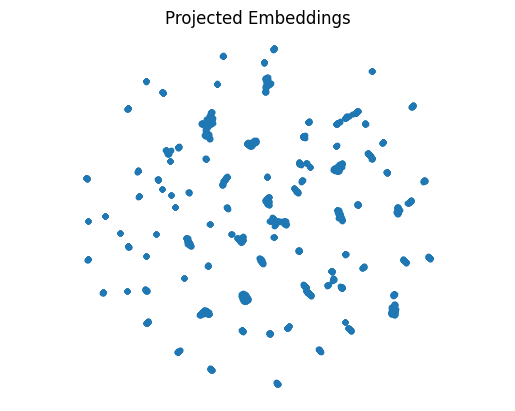

In [7]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

### Visualize Example Query In Embedding Space

amount contained in collection: 2961
number of results: 10


100%|██████████| 10/10 [00:00<00:00, 59.60it/s]


(np.float64(-20.997716331481932),
 np.float64(25.388757133483885),
 np.float64(-18.256585311889648),
 np.float64(26.987981033325195))

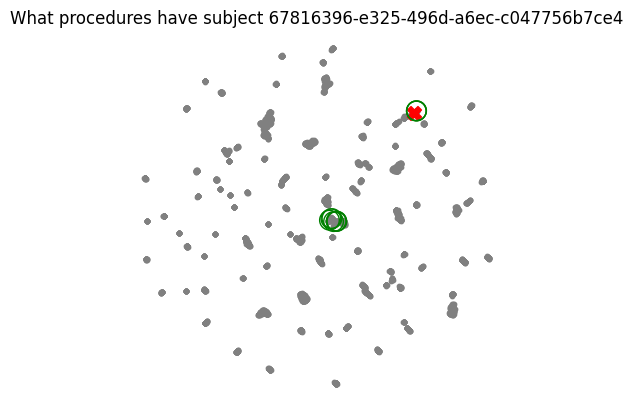

In [32]:
chroma_client = vectordb._client
collection = chroma_client.get_or_create_collection(name="langchain")
print("amount contained in collection:", collection.count())

query = "What procedures have subject 67816396-e325-496d-a6ec-c047756b7ce4"
results = collection.query(
    query_texts=[query],
    n_results=10,
    include=['documents', 'embeddings']
)
print("number of results:", len(results['documents'][0]))

query_embedding = embedding.embed_query(query)
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=100, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=200, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

It's odd to see that the majority of the results are so far from the query. Especially odd, because there should be more than one procedure for that subject/Patient

In [36]:
import json

def parse_result_docs_for_subject(docs):
    for doc in docs:
        page_json = json.loads(doc)
        if page_json["resourceType"] and page_json["resourceType"] in ["Procedure", "Condition", "Encounter", "Observation"]:
            print(page_json["subject"])
        else:
            print(page_json)

parse_result_docs_for_subject(results['documents'][0])

{'reference': 'urn:uuid:668605fe-a8dc-4601-ae48-f5bc24bbea74'}
{'reference': 'urn:uuid:668605fe-a8dc-4601-ae48-f5bc24bbea74'}
{'reference': 'urn:uuid:668605fe-a8dc-4601-ae48-f5bc24bbea74'}
{'reference': 'urn:uuid:5cbc121b-cd71-4428-b8b7-31e53eba8184'}
{'reference': 'urn:uuid:5cbc121b-cd71-4428-b8b7-31e53eba8184'}
{'reference': 'urn:uuid:668605fe-a8dc-4601-ae48-f5bc24bbea74'}
{'reference': 'urn:uuid:adccf2c3-9dc4-4067-ba23-98982c4875da', 'display': 'Mr. Aaron697 Stiedemann542'}
{'reference': 'urn:uuid:adccf2c3-9dc4-4067-ba23-98982c4875da', 'display': 'Mr. Aaron697 Stiedemann542'}
{'reference': 'urn:uuid:adccf2c3-9dc4-4067-ba23-98982c4875da', 'display': 'Mr. Aaron697 Stiedemann542'}
{'reference': 'urn:uuid:5cbc121b-cd71-4428-b8b7-31e53eba8184'}


Well to start with, none of the results are for subject `67816396-e325-496d-a6ec-c047756b7ce4` ☹

## Try Query Expansion

Ask LLM to come up with additional questions along the lines of the provided user question and apply those to the VectorDB in addition to the provided user question.

## Try Cross-encoder Re-ranking

Cross-encoders are a different method for encoding queries that are related, rather than treating them as independent.... I think 🤔

## Try Embedding Adaptors

## Try Other Techniques